Introduction
----------------
Self-organizing maps are computationally intensive to train, especially if the original space is high-dimensional or the map is large. Very large maps where the number of neurons is at least five times the number of data points are sometimes called emergent-self organizing maps -- these are especially demanding to train. [Somoclu](http://peterwittek.github.io/somoclu/) is a highly efficient, parallel and distributed algorithm to train such maps, and its Python interface was recently updated. This enables fast training of self-organizing maps on multicore CPUs or a GPU from Python, albeit only on dense data, and the distributed computing capability is also not exposed. The Python interface also lets you process the output files of the command-line version, so if the data is sparse or the map was trained on a cluster, you can still use the module for visualization. Here we take a quick look at how to train and visualize a small map.

First, we import the necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import somoclu
%matplotlib inline  

Then we generate and plot some random data in three categories:

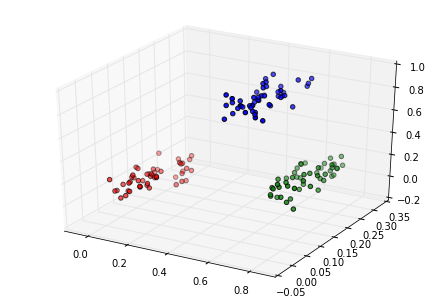

In [2]:
c1 = np.random.rand(50, 3)/5
c2 = (0.6, 0.1, 0.05) + np.random.rand(50, 3)/5
c3 = (0.4, 0.1, 0.7) + np.random.rand(50, 3)/5
data = np.float32(np.concatenate((c1, c2, c3)))
colors = ["red"] * 50
colors.extend(["green"] * 50)
colors.extend(["blue"] * 50)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors)
labels = range(150)

Planar maps
---------------
We train Somoclu with default parameter settings, asking for a large map that qualifies as an emergent self-organizing map for this data:

In [4]:
n_rows, n_columns = 100, 160
som = somoclu.Somoclu(n_columns, n_rows, data=data)
%time som.train()

CPU times: user 6.98 s, sys: 3.33 ms, total: 6.98 s
Wall time: 5.22 s


We plot the component planes of the trained codebook of the ESOM:

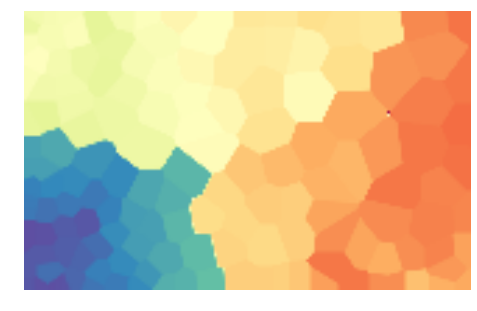

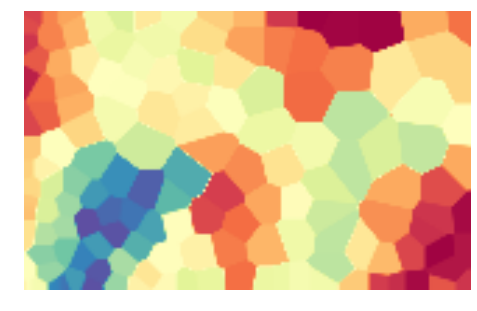

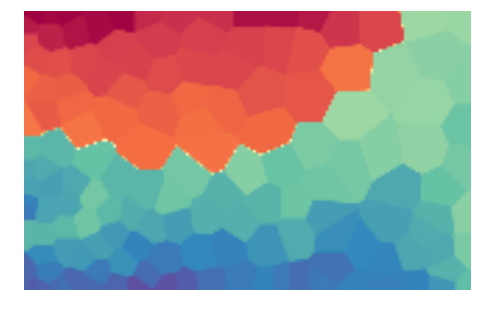

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [5]:
som.view_component_planes()

We can plot the U-Matrix, together with the best matching units for each data point. We color code the units with the classes of the data points and also add the labels of the data points.

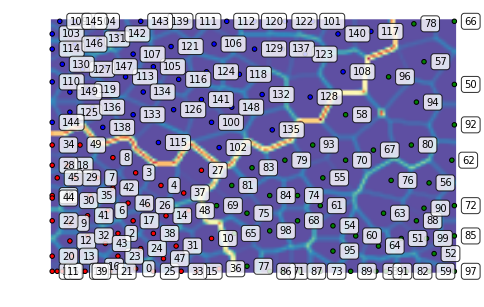

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [6]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)

We can also zoom into a region of interest, for instance, the dense lower right corner:

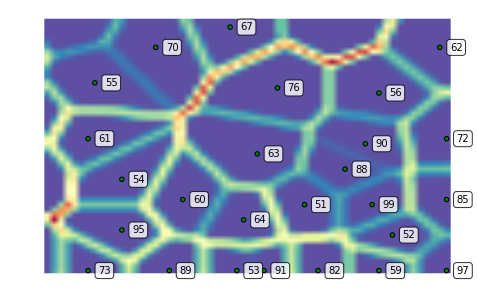

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [7]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels, 
                 zoom=((50, n_rows), (100, n_columns)))

Toroid topology, hexagonal grid
-----------------------------------------
We can repeat the above with a toroid topology by specifying the map type as follows:

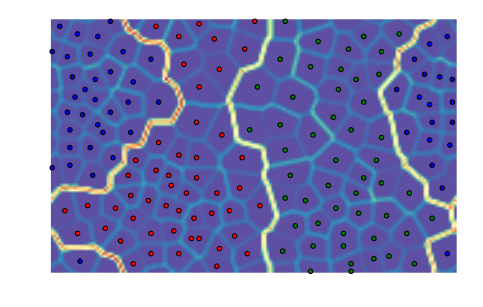

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [9]:
som = somoclu.Somoclu(n_columns, n_rows, data=data, maptype="toroid")
som.train()
som.view_umatrix(bestmatches=True, bestmatchcolors=colors)

Notice how the edges of the map connect to the other side. Hexagonal neurons are also implemented:

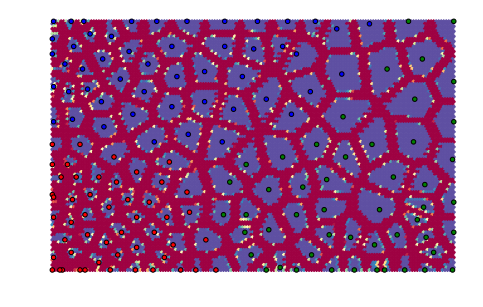

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [10]:
som = somoclu.Somoclu(n_columns, n_rows, data=data, gridtype="hexagonal")
som.train()
som.view_umatrix(bestmatches=True, bestmatchcolors=colors)

The separation of the individual points is more marked with these neurons.

Initialization with principal component analysis and clustering the results
---------------------------------------------------------------------------
We can pass an initial codebook of our choice, but we can also ask Somoclu to initialize the codebook with vectors from the subspace spanned by the first two eigenvalues of the correlation matrix. To do this, we need to pass an optional argument to the constructor:

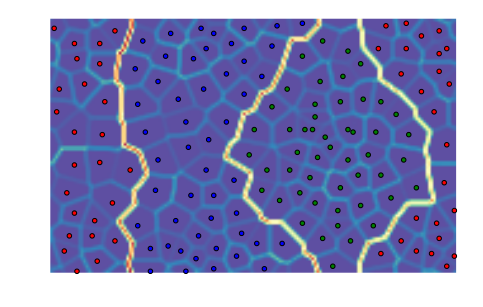

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [14]:
som = somoclu.Somoclu(n_columns, n_rows, data=data, maptype="toroid", initialization="pca")
som.train()
som.view_umatrix(bestmatches=True, bestmatchcolors=colors)

While one would expect entirely deterministic results on repeated runs with the initialization based on PCA, this is not the case. The order in which the data instances arrive matters: since Somoclu uses multiple cores, there is no control over the order of each batch, hence the maps will show small variation even with a PCA initalization.

We can also postprocess the codebook with an arbitrary clustering algorithm that is included in [scikit-learn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster). The default algorithm is K-means with eight clusters. After clustering, the labels for each node are available in the SOM object in the ``clusters`` class variable. If we do not pass colors to the matrix viewing functions and clustering is already done, the plotting routines automatically color the best matching units according to the clustering structure. 

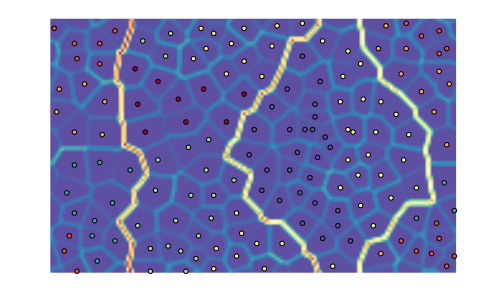

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [16]:
som.cluster()
som.view_umatrix(bestmatches=True)

We can, of course, choose another clustering algorithm, but topological clustering methods will make little sense with their default parameterization. DBSCAN, for instance, will assign the same class to all nodes:

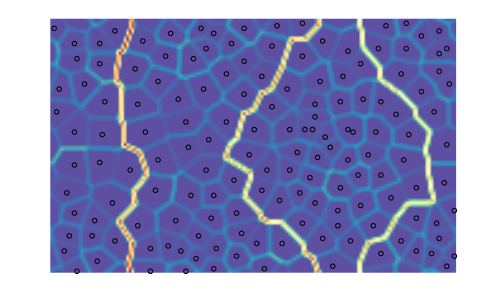

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [17]:
from sklearn.cluster import DBSCAN
algorithm = DBSCAN()
som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True)

Evolving maps
------------------
One of the great advantages of self-organizing maps is that they are incremental, they can be updated with new data. This is especially interesting if the data points retain their old label, that is, the properties of the vectors change in the high-dimensional space. Let us train again a toroid rectangular emergent map on the same data:

In [11]:
som = somoclu.Somoclu(n_columns, n_rows, data=data, maptype="toroid")
som.train()

Next, let us assume that the green cluster moves to the left, the other points remaining invariant:

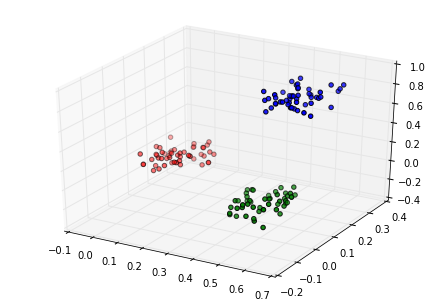

In [12]:
c2_shifted = c2 - 0.2
updated_data = np.float32(np.concatenate((c1, c2_shifted, c3)))
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(updated_data[:, 0], updated_data[:, 1], updated_data[:, 2], c=colors)

We can update the map to reflect this shift. We plot the map before and after continuing the training:

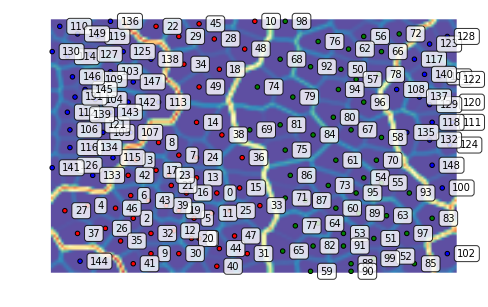

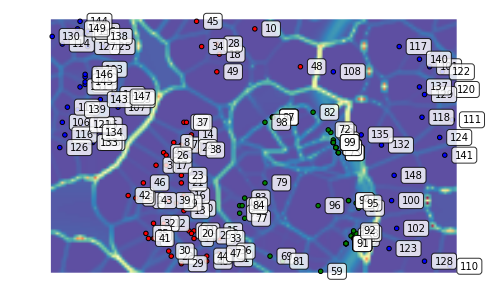

<module 'matplotlib.pyplot' from '/usr/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [13]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)
som.update_data(updated_data)
som.train(epochs=2, radius0=20, scale0=0.02)
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)

As a result of the shift, the blue points do not move around much. On the other hand, the relationship of the red and green clusters is being redefined as their coordinates inched closer in the original space.